# Content filtering validation

Thanks to the preprocessing pipeline, reviews were filtered based on their content. A dataset containing only reviews related to identified special needs (pets, children, disabilities) was created. To segment these reviews, a keyword search using regex was applied.

To verify that the selected reviews are indeed relevant to special needs, a validation model can be used.

Validation with a zero-shot classification model involves using a pre-trained NLP model capable of classifying text into defined categories.

Four categories were defined: pets, children, disability, and others.

Device set to use cpu


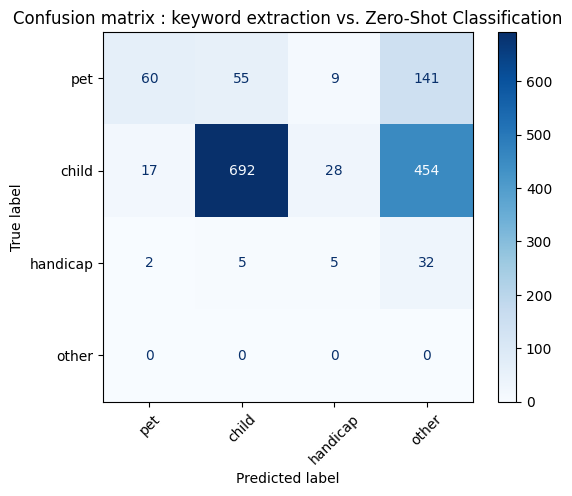

In [4]:
# 2:32
import torch
from transformers import pipeline
import polars as pl
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# --- 1. Charger le modèle Zero-Shot ---
pipe = pipeline(
    "zero-shot-classification",
    #model="facebook/bart-large-mnli"
    model = "typeform/distilbert-base-uncased-mnli"
)

# --- 2. Charger les données ---
df = pl.read_csv("../../data/processed/key_word_test_a_supprimer.csv")
df = df.sample(n=1500, with_replacement=False, shuffle=True)

# --- 3. Labels à tester ---
labels = ["pet", "child", "handicap", "other"] #vrai label

#juste pour le test
#labels = ["pets", "children", "handicap", "other"]

# --- 4. Appliquer le modèle à chaque texte ---
predicted = []
texts = df["review"].to_list()

for r in texts:
    result = pipe(r, candidate_labels=labels, multi_label=False)
    predicted.append(result["labels"][0])  # catégorie avec le plus haut score

# --- 5. Ajouter la colonne dans le DataFrame ---
df = df.with_columns(pl.Series("predicted_category", predicted))

# --- 6. Comparer les colonnes avec une matrice de confusion ---
true = df["category"].to_list()
pred = df["predicted_category"].to_list()

cm = confusion_matrix(true, pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion matrix : keyword extraction vs. Zero-Shot Classification")
plt.show()

model = facebook/bart-large-mnli (lourd)
model = "typeform/distilbert-base-uncased-mnli" (plus leger)

Computational time (on activities)

100 -> 2:32 (lourd)
1000 -> 5:56 (lourd)

200 -> 0:36 (leger)
400 -> 1:03 (leger)
800 -> 2:25
1500 -> 4:21


In [5]:
import torch
torch.set_num_threads(4)
from transformers import pipeline
import polars as pl
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- 1. Charger le modèle ---
device = 0 if torch.cuda.is_available() else -1
pipe = pipeline(
    "zero-shot-classification",
    model="typeform/distilbert-base-uncased-mnli",
    device=device
)

# --- 2. Charger les données ---
df = pl.read_csv("../../data/processed/key_word_test_a_supprimer.csv")
df = df.sample(n=1500, with_replacement=False, shuffle=True)

labels = ["pet", "child", "handicap", "other"]
texts = df["review"].to_list()

# --- 3. Prédiction par batch ---
batch_size = 32
predicted = []

for i in tqdm(range(0, len(texts), batch_size)):
    batch = texts[i:i+batch_size]
    results = pipe(batch, candidate_labels=labels, multi_label=False)
    # results est une liste de dicts
    predicted.extend([r["labels"][0] for r in results])

# --- 4. Fusionner les résultats ---
df = df.with_columns(pl.Series("predicted_category", predicted))

df = df.with_columns(
    (pl.col("predicted_category") == pl.col("category")).alias("category_is_confirmed")
)

# --- 5. Matrice de confusion ---
true = df["category"].to_list()
pred = df["predicted_category"].to_list()

cm = confusion_matrix(true, pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion matrix : keyword extraction vs. Zero-Shot Classification")
plt.show()


Device set to use cpu
  6%|▋         | 3/47 [00:38<09:21, 12.76s/it]


KeyboardInterrupt: 

100 -> 0:25
200 -> 0:40
400 -> 1:15
800 -> 2:23
1500 -> 4:25